In [1]:
using Revise

In [2]:
using Images, ImageIO
using LinearAlgebra
using OpenCV
using CSV
using DataFrames
using Flux
using ONNXNaiveNASflux, NaiveNASflux

In [3]:

function square_img(image, bbox, img_size)
    bbox_width = round(Int, bbox["bbox_x2"] - bbox["bbox_x1"])
    bbox_height = round(Int, bbox["bbox_y2"] - bbox["bbox_y1"])
    offset_tl = Int.([bbox["bbox_x1"], bbox["bbox_y1"]] .+ 1)
    h, _ = img_size
    if bbox_width >= bbox_height
        sq_img = zeros(UInt8, bbox_width, bbox_width, 3)
        if bbox_width >= h
            crop_img = image[:, offset_tl[1]: offset_tl[1] + bbox_width - 1, :]
            offset_tl[2] = 1
            bbox_height = h
        elseif offset_tl[2] + bbox_width - 1 >= h
            offset_tl[2] = h + 1 - bbox_width
            bbox_height = bbox_width
            crop_img = image[offset_tl[2] : offset_tl[2] + bbox_width - 1, offset_tl[1] : offset_tl[1] + bbox_width - 1, :]
        else
            crop_img = image[offset_tl[2] : offset_tl[2] + bbox_width - 1, offset_tl[1] : offset_tl[1] + bbox_width - 1, :]
            bbox_height = bbox_width
        end
        sq_img[1:bbox_height, 1:bbox_width, :] = crop_img
    else
        sq_img = zeros(UInt8, bbox_height, bbox_height, 3)
    end
    return sq_img, offset_tl
end

function preprocess_image(img_path, csv_path)
    image = OpenCV.imread(img_path)
    image = OpenCV.resize(image, OpenCV.Size{Int32}(1920, 1200), interpolation=OpenCV.INTER_AREA)
    _, w, h = size(image)  # (3, 1920, 1200)
    # CWH, BGR channel for Julia OpenCV, we desire WHCN for Flux model
    image = OpenCV.cvtColor(image, OpenCV.COLOR_BGR2GRAY)
    image = OpenCV.cvtColor(image, OpenCV.COLOR_GRAY2RGB)
    image = permutedims(image, (3, 2, 1))
    
    truth_df = DataFrame(CSV.File(csv_path))
    bbox = truth_df[!, [:bbox_x1, :bbox_y1, :bbox_x2, :bbox_y2]]
    bbox = bbox[parse(Int, split(img_path[1:end-4], '_')[end]) + 1, :]
    sq_image, offset_tl = square_img(image, bbox, (h, w))
    input_size = 256
    sq_image = permutedims(sq_image, (3, 2, 1))  # no need to permute multiple times, will remove it later
    resize_img = OpenCV.resize(sq_image, OpenCV.Size{Int32}(input_size, input_size), interpolation=OpenCV.INTER_AREA)
    resize_img = resize_img / 255.0
    resize_img = permutedims(resize_img, (3, 2, 1))

    resize_img = reshape(resize_img, (size(resize_img)...,1))   # WHCN for Julia, NCHW for Python
    resize_img = permutedims(resize_img, (2, 1, 3, 4))
    img_mean = reshape([0.48500, 0.45600, 0.40600], (1, 1, 3, 1))
    img_variance = reshape([0.2990, 0.22400, 0.22500], (1, 1, 3, 1))
    resize_img = (resize_img .- img_mean) ./ img_variance;
    return Float32.(resize_img)
end

function get_parallel_chains(comp_vertices, index_more_than_one_outputs)
    function get_chain(vertex)
        m = Any[]
        curr_vertex = vertex
        while length(inputs(curr_vertex)) == 1
            # println("curr vertex ", name(curr_vertex))
            push!(m, layer(curr_vertex))
            curr_vertex = outputs(curr_vertex)[1]
        end
        return Chain(m...), curr_vertex
    end
    outs = outputs(comp_vertices[index_more_than_one_outputs])
    @assert length(outs) == 2
    chain1, vertex_more_than_one_inputs = get_chain(outs[1])
    chain2, _ = get_chain(outs[2])
    @assert occursin("Add", name(vertex_more_than_one_inputs))
    inner_iter = findfirst(v -> name(v) == name(vertex_more_than_one_inputs), comp_vertices)
    if length(chain1) == 0
        return SkipConnection(chain2, (+)), inner_iter
    elseif length(chain2) == 0
        return SkipConnection(chain1, (+)), inner_iter
    else
        return Parallel(+; α = chain1, β = chain2), inner_iter
    end
end

function build_flux_model(onnx_model_path)
    comp_graph = ONNXNaiveNASflux.load(onnx_model_path)

    model_vec = Any[]

    inner_iter = 0
    for (index, vertex) in enumerate(ONNXNaiveNASflux.vertices(comp_graph))
        if index < 5 || index <= inner_iter
            continue
        end 
        if string(layer(vertex)) == "#213"
            push!(model_vec, NNlib.relu)
        else
            push!(model_vec, layer(vertex))
        end
        if length(outputs(vertex)) > 1
            # println("name: ", name(vertex))
            parallel_chain, inner_iter = get_parallel_chains(ONNXNaiveNASflux.vertices(comp_graph), index)
            push!(model_vec, parallel_chain)
        end
    end
    # model_vec = model_vec[1:end-1]
    push!(model_vec, Flux.MeanPool((32,32)))
    push!(model_vec, Flux.flatten)
    model = Chain(model_vec...)
    Flux.testmode!(model)
    return (model)
end

build_flux_model (generic function with 1 method)

In [4]:
# +++++++++++++++++++ build flux model +++++++++++++++++++
onnx_model_path = "./resnet_model.onnx"
model = build_flux_model(onnx_model_path)

Set(Any["BatchNormalization", "Div", "Relu", "Constant", "Sub", "Conv", "ConvTranspose", "AveragePool", "Add"])


Chain(
  Conv((7, 7), 3 => 64, pad=3, stride=2, bias=false),  # 9_408 parameters
  BatchNorm(64, relu, active=false),    # 128 parameters, plus 128
  MeanPool((3, 3), pad=1, stride=2),
  SkipConnection(
    Chain(
      Conv((3, 3), 64 => 64, pad=1, bias=false),  # 36_864 parameters
      BatchNorm(64, relu, active=false),  # 128 parameters, plus 128
      Conv((3, 3), 64 => 64, pad=1, bias=false),  # 36_864 parameters
      BatchNorm(64, active=false),      # 128 parameters, plus 128
    ),
    +,
  ),
  ONNXNaiveNASflux.var"#217#229"{typeof(relu)}(NNlib.relu),
  SkipConnection(
    Chain(
      Conv((3, 3), 64 => 64, pad=1, bias=false),  # 36_864 parameters
      BatchNorm(64, relu, active=false),  # 128 parameters, plus 128
      Conv((3, 3), 64 => 64, pad=1, bias=false),  # 36_864 parameters
      BatchNorm(64, active=false),      # 128 parameters, plus 128
    ),
    +,
  ),
  ONNXNaiveNASflux.var"#217#229"{typeof(relu)}(NNlib.relu),
  Parallel(
    +,
    α = Chain(
      Conv((3

In [5]:
using LazySets
using ModelVerification
using Test
using Profile
using Plots

In [6]:
# # +++++++++++++++++++ preprocess image +++++++++++++++++++
img_path = "./AircraftInspection_00000008.png"
csv_path = "./SynthPlane_08.csv"
img = preprocess_image(img_path, csv_path)
input = Float32.(img);

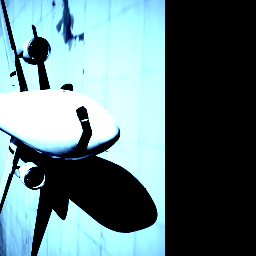

In [7]:
colorview(RGB, permutedims(input[:, :, :, 1], [3,1,2]))

In [8]:
output = model(input);

In [9]:
input = reshape(input, 256, 256, 3)
input_perturbed = copy(input);
# input_perturbed[100:102,100:102,1:3,1] .= -0.5
# input_perturbed[1,1,1,1] = -0.5
# input_perturbed[100,100,1,1] = -0.5
# input_perturbed[100,100,1,1] = -0.5
# input_perturbed[100,100,1:3,1] .= -0.5
# input_perturbed[100:105,100:105,1:3,1] .= -0.5

256×256×3 Array{Float32, 3}:
[:, :, 1] =
 0.187881   -1.14991   -1.12368    -0.822021  …  -1.62207  -1.62207  -1.62207
 0.358384   -0.91383   -1.17614    -1.1368       -1.62207  -1.62207  -1.62207
 0.3715     -0.599056  -1.20237    -1.16303      -1.62207  -1.62207  -1.62207
 0.397731   -0.244934  -1.20237    -1.09745      -1.62207  -1.62207  -1.62207
 0.437078    0.109187  -1.21549    -1.08433      -1.62207  -1.62207  -1.62207
 0.463309    0.358384  -1.04499    -1.1368    …  -1.62207  -1.62207  -1.62207
 0.48954     0.410847  -0.703981   -1.17614      -1.62207  -1.62207  -1.62207
 0.502656    0.437078  -0.389206   -1.21549      -1.62207  -1.62207  -1.62207
 0.528887    0.463309   0.0173782  -1.21549      -1.62207  -1.62207  -1.62207
 0.542003    0.476425   0.305922   -1.11056      -1.62207  -1.62207  -1.62207
 ⋮                                            ⋱                       ⋮
 0.109187    0.16165    0.148534    0.266575     -1.62207  -1.62207  -1.62207
 0.109187    0.135419   0.174

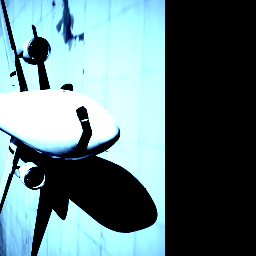

In [10]:
colorview(RGB, permutedims(input_perturbed[:, :, :, 1], [3,1,2]))

In [11]:
testmode!(model)
prop_method = ImageZono()
search_method = BFS(max_iter=1, batch_size=1)
split_method = Bisect(1)
output_set = BallInf(zeros(1536), 1.0)

BallInf{Float64, Vector{Float64}}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1.0)

In [19]:
input_perturbed = copy(input);
input_perturbed[100,100,1,1] = -0.5
image_seeds = ImageConvexHull([input, input_perturbed])  # 256 x 256 x 3 x 2
visualize(search_method, split_method, prop_method, Problem(model, image_seeds, output_set), "center_100_100/")

Set(Any["BatchNormalization", "Flatten", "Relu", "ConvTranspose", "Conv", "AveragePool", "Add"])
size(bound.generators): (256, 256, 3, 1)
prop time:0.017915303
comp time:0.007944672
saving visualized bound: center_100_100/1_conv_0.png
bound time:0.003532571
prop time:

0.001833842
comp time:0.000955902
saving visualized bound: center_100_100/2_batchnorm_0.png
bound time:0.00352139
before order: 9.5367431640625e-7
non0 ele cnt: 896
overapproximate time: 0.034574914
after order: 1.430511474609375e-5
after reducing order: 

4.76837158203125e-6
before size: (128, 128, 64, 1)
after size: (128, 128, 64, 5)
prop time:7.290973807
comp time:0.000668795
saving visualized bound: center_100_100/3_batchnorm_0_relu.png
bound time:0.004615385


prop time:0.005782753
comp time:0.000894951
saving visualized bound: center_100_100/4_averagepool_0.png
bound time:0.001099945
size(bound.generators): (64, 64, 64, 5)
prop time:0.026799303
comp time:0.00304514
saving visualized bound: center_100_100/5_conv_1.png
bound time:0.000955642
prop time:0.000818039
comp time:0.000124113
saving visualized bound: center_100_100/6_batchnorm_1.png
bound time:0.00083246
before order: 

1.9073486328125e-5
non0 ele cnt: 1600
overapproximate time: 0.003878108
after order: 3.0517578125e-5
after reducing order: 

7.62939453125e-6
before size: (64, 64, 64, 5)
after size: (64, 64, 64, 2)
prop time:0.977089334
comp time:0.000129113
saving visualized bound: center_100_100/7_batchnorm_1_relu.png
bound time:0.000502851
size(bound.generators): (64, 64, 64, 2)
prop time:0.015252179
comp time:0.00356245
saving visualized bound: center_100_100/8_conv_2.png
bound time:0.000550472
prop time:0.00043977
comp time:0.000113593
saving visualized bound: center_100_100/9_batchnorm_2.png
bound time:0.000447721
add_0


+
saving visualized bound: center_100_100/10_add_0.png
bound time:0.001237759
before order: 2.6702880859375e-5
non0 ele cnt: 3136
overapproximate time: 0.010903588
after order: 7.62939453125e-5
after reducing order: 

1.9073486328125e-5
before size: (64, 64, 64, 7)
after size: (64, 64, 64, 5)
prop time:3.101654335
comp time:0.000119343
saving visualized bound: center_100_100/11_relu_0.png
bound time:0.00090231
size(bound.generators): (64, 64, 64, 5)
prop time:0.029976143
comp time:0.003127752
saving visualized bound: center_100_100/12_conv_3.png
bound time:0.000978802
prop time:0.000779338
comp time:0.000116892
saving visualized bound: center_100_100/13_batchnorm_3.png
bound time:0.00087022
before order: 

1.9073486328125e-5
non0 ele cnt: 5184
overapproximate time: 0.007252046
after order: 7.2479248046875e-5
after reducing order: 

1.1444091796875e-5
before size: (64, 64, 64, 5)
after size: (64, 64, 64, 3)
prop time:2.759744464
comp time:0.000131943
saving visualized bound: center_100_100/14_batchnorm_3_relu.png
bound time:0.000593153
size(bound.generators): (64, 64, 64, 3)
prop time:0.019206746
comp time:0.0031069
saving visualized bound: center_100_100/15_conv_4.png
bound time:0.000655115
prop time:0.000547752
comp time:0.000110242
saving visualized bound: center_100_100/16_batchnorm_4.png
bound time:0.000632694
add_1


+
saving visualized bound: center_100_100/17_add_1.png
bound time:0.001430512
before order: 3.0517578125e-5
non0 ele cnt: 7744
overapproximate time: 0.015694666
after order: 0.000118255615234375
after reducing order: 

3.0517578125e-5
before size: (64, 64, 64, 8)
after size: (64, 64, 64, 8)
prop time:4.16937179
comp time:0.000121393
saving visualized bound: center_100_100/18_relu_1.png
bound time:0.001469173
size(bound.generators): (64, 64, 64, 8)
prop time:0.027519351
comp time:0.001421252
saving visualized bound: center_100_100/19_conv_5.png
bound time:0.000597724


size(bound.generators): (64, 64, 64, 8)
prop time:0.004341708
comp time:0.000324117
saving visualized bound: center_100_100/20_conv_7.png
bound time:0.000625714
prop time:0.00090655
comp time:7.4221e-5
saving visualized bound: center_100_100/21_batchnorm_5.png
bound time:0.000576863
prop time:0.000605654
comp time:7.1042e-5
saving visualized bound: center_100_100/22_batchnorm_7.png
bound time:0.000579673
before order: 6.103515625e-5
non0 ele cnt: 4607
overapproximate time: 0.004717126
after order: 0.00020599365234375
after reducing order: 

3.814697265625e-5
before size: (32, 32, 128, 8)
after size: (32, 32, 128, 5)
prop time:2.910395369
comp time:6.9192e-5
saving visualized bound: center_100_100/23_batchnorm_5_relu.png
bound time:0.000409929
size(bound.generators): (32, 32, 128, 5)
prop time:0.024691038
comp time:0.002340863
saving visualized bound: center_100_100/24_conv_6.png
bound time:0.00045014
prop time:0.00044558
comp time:6.7201e-5
saving visualized bound: center_100_100/25_batchnorm_6.png
bound time:0.000396929
add_2


+
saving visualized bound: center_100_100/26_add_2.png
bound time:0.001058994
before order: 9.918212890625e-5
non0 ele cnt: 8187
overapproximate time: 0.007131741
after order: 0.00016021728515625
after reducing order: 

5.340576171875e-5
before size: (32, 32, 128, 13)
after size: (32, 32, 128, 7)
prop time:3.930816393
comp time:6.9171e-5
saving visualized bound: center_100_100/27_relu_2.png
bound time:0.000529042
size(bound.generators): (32, 32, 128, 7)
prop time:0.031130821
comp time:0.002396073
saving visualized bound: center_100_100/28_conv_8.png
bound time:0.000634595
prop time:0.000551163
comp time:7.1862e-5
saving visualized bound: center_100_100/29_batchnorm_8.png
bound time:0.000761238
before order: 

5.340576171875e-5
non0 ele cnt: 12776
overapproximate time: 0.002954596
after order: 9.918212890625e-5
after reducing order: 

1.52587890625e-5
before size: (32, 32, 128, 7)
after size: (32, 32, 128, 2)
prop time:1.13064368
comp time:7.0621e-5
saving visualized bound: center_100_100/30_batchnorm_8_relu.png
bound time:0.000265886
size(bound.generators): (32, 32, 128, 2)
prop time:0.012239085
comp time:0.003804755
saving visualized bound: center_100_100/31_conv_9.png
bound time:0.000300707
prop time:0.000253166
comp time:6.7462e-5
saving visualized bound: center_100_100/32_batchnorm_9.png
bound time:0.000299197
add_3
+
saving visualized bound: center_100_100/33_add_3.png
bound time:0.000635584
before order: 

6.866455078125e-5
non0 ele cnt: 18157
overapproximate time: 0.004845819
after order: 0.0001983642578125
after reducing order: 

5.340576171875e-5
before size: (32, 32, 128, 9)
after size: (32, 32, 128, 7)
prop time:2.937469049
comp time:7.0232e-5
saving visualized bound: center_100_100/34_relu_3.png
bound time:0.000521722
size(bound.generators): (32, 32, 128, 7)
prop time:0.017085273
comp time:0.001456513
saving visualized bound: center_100_100/35_conv_10.png
bound time:0.000244105
size(bound.generators): (32, 32, 128, 7)
prop time:0.002502546
comp time:0.000234305
saving visualized bound: center_100_100/36_conv_12.png
bound time:0.000252045
prop time:0.000361148
comp time:4.5901e-5
saving visualized bound: center_100_100/37_batchnorm_10.png
bound time:0.000261126
prop time:

0.000384439
comp time:4.5351e-5
saving visualized bound: center_100_100/38_batchnorm_12.png
bound time:0.000278937
before order: 0.0001068115234375
non0 ele cnt: 12299
overapproximate time: 0.001246838
after order: 0.0001678466796875
after reducing order: 

1.52587890625e-5
before size: (16, 16, 256, 7)
after size: (16, 16, 256, 1)
prop time:0.415087298
comp time:4.8551e-5
saving visualized bound: center_100_100/39_batchnorm_10_relu.png
bound time:0.000118082
size(bound.generators): (16, 16, 256, 1)
prop time:0.008116561
comp time:0.003701123
saving visualized bound: center_100_100/40_conv_11.png
bound time:0.000101533
prop time:0.000170134
comp time:4.3001e-5
saving visualized bound: center_100_100/41_batchnorm_11.png
bound time:0.000102343
add_4
+
saving visualized bound: center_100_100/42_add_4.png
bound time:0.000280326
before order: 0.0001220703125
non0 ele cnt: 19574
overapproximate time: 0.001222798
after order: 0.000152587890625
after reducing order: 

1.52587890625e-5
before size: (16, 16, 256, 8)
after size: (16, 16, 256, 1)
prop time:0.375079091
comp time:5.2511e-5
saving visualized bound: center_100_100/43_relu_4.png
bound time:0.000112223
size(bound.generators): (16, 16, 256, 1)
prop time:0.006882134
comp time:0.003375904
saving visualized bound: center_100_100/44_conv_13.png
bound time:9.8252e-5
prop time:0.000167214
comp time:4.6962e-5
saving visualized bound: center_100_100/45_batchnorm_13.png
bound time:0.000100243
before order: 1.52587890625e-5
non0 ele cnt: 27690
overapproximate time: 0.00044155
after order: 3.0517578125e-5
after reducing order: 

1.52587890625e-5
before size: (16, 16, 256, 1)
after size: (16, 16, 256, 1)
prop time:0.042707896
comp time:4.9361e-5
saving visualized bound: center_100_100/46_batchnorm_13_relu.png
bound time:0.000105752
size(bound.generators): (16, 16, 256, 1)
prop time:0.006799032
comp time:0.003265192
saving visualized bound: center_100_100/47_conv_14.png
bound time:9.6882e-5
prop time:0.000158793
comp time:4.0441e-5
saving visualized bound: center_100_100/48_batchnorm_14.png
bound time:7.1782e-5
add_5
+
saving visualized bound: center_100_100/49_add_5.png
bound time:0.000122633
before order: 3.0517578125e-5
non0 ele cnt: 36687
overapproximate time: 0.000478191
after order: 4.57763671875e-5
after reducing order: 

1.52587890625e-5
before size: (16, 16, 256, 2)
after size: (16, 16, 256, 1)
prop time:0.08392747
comp time:4.8381e-5
saving visualized bound: center_100_100/50_relu_5.png
bound time:0.000109452
size(bound.generators): (16, 16, 256, 1)
prop time:0.005240688
comp time:0.00265412
saving visualized bound: center_100_100/51_conv_15.png
bound time:5.4741e-5
size(bound.generators): (16, 16, 256, 1)
prop time:0.000987323
comp time:0.000381999
saving visualized bound: center_100_100/52_conv_17.png
bound time:5.7941e-5
prop time:0.000168634
comp time:4.4661e-5
saving visualized bound: center_100_100/53_batchnorm_15.png
bound time:5.8611e-5
prop time:0.000166673
comp time:4.3371e-5
saving visualized bound: center_100_100/54_batchnorm_17.png
bound time:5.8181e-5
before order: 

3.0517578125e-5
non0 ele cnt: 22673
overapproximate time: 0.000234145
after order: 3.0517578125e-5
after reducing order: 3.0517578125e-5
before size: (8, 8, 512, 1)
after size: (8, 8, 512, 1)
prop time:0.000581593
comp time:2.501e-5
saving visualized bound: center_100_100/55_batchnorm_15_relu.png
bound time:4.9981e-5
size(bound.generators): (8, 8, 512, 1)
prop time:0.010730531
comp time:0.004760807
saving visualized bound: center_100_100/56_conv_16.png
bound time:5.7391e-5
prop time:0.000165164
comp time:4.2121e-5
saving visualized bound: center_100_100/57_batchnorm_16.png
bound time:5.9851e-5
add_6
+
saving visualized bound: center_100_100/58_add_6.png
bound time:5.7341e-5
before order: 6.103515625e-5
non0 ele cnt: 30748
overapproximate time: 0.000291197
after order: 0.0001220703125
after reducing order: 

3.0517578125e-5
before size: (8, 8, 512, 2)
after size: (8, 8, 512, 1)
prop time:0.063597073
comp time:3.1241e-5
saving visualized bound: center_100_100/59_relu_6.png
bound time:6.2191e-5
size(bound.generators): (8, 8, 512, 1)
prop time:0.010539987
comp time:0.004492309
saving visualized bound: center_100_100/60_conv_18.png
bound time:5.6421e-5
prop time:0.000161834
comp time:5.1171e-5
saving visualized bound: center_100_100/61_batchnorm_18.png
bound time:5.8231e-5
before order: 3.0517578125e-5
non0 ele cnt: 32339
overapproximate time: 0.000234985
after order: 3.0517578125e-5
after reducing order: 3.0517578125e-5
before size: (8, 8, 512, 1)
after size: (8, 8, 512, 1)
prop time:0.000507531
comp time:2.4921e-5
saving visualized bound: center_100_100/62_batchnorm_18_relu.png
bound time:5.1232e-5


size(bound.generators): (8, 8, 512, 1)
prop time:0.13946361
comp time:0.004513561
saving visualized bound: center_100_100/63_conv_19.png
bound time:6.3351e-5
prop time:0.000164493
comp time:4.2901e-5
saving visualized bound: center_100_100/64_batchnorm_19.png
bound time:6.8161e-5
add_7
+
saving visualized bound: center_100_100/65_add_7.png
bound time:8.1732e-5
before order: 6.103515625e-5
non0 ele cnt: 32479
overapproximate time: 0.000233705
after order: 6.103515625e-5
after reducing order: 3.0517578125e-5
before size: (8, 8, 512, 2)
after size: (8, 8, 512, 1)
prop time:0.020416067
comp time:4.0741e-5
saving visualized bound: center_100_100/66_relu_7.png
bound time:5.3061e-5


size(bound.generators): (8, 8, 512, 1)
prop time:0.002810313
comp time:0.001319959
saving visualized bound: center_100_100/67_convtranspose_0.png
bound time:9.9592e-5
prop time:0.000172134
comp time:4.8181e-5
saving visualized bound: center_100_100/68_batchnorm_20.png
bound time:0.000103543
before order: 1.52587890625e-5
non0 ele cnt: 64355
overapproximate time: 0.000569093
after order: 4.57763671875e-5
after reducing order: 

1.52587890625e-5
before size: (16, 16, 256, 1)
after size: (16, 16, 256, 1)
prop time:0.080783909
comp time:4.9121e-5
saving visualized bound: center_100_100/69_batchnorm_20_relu.png
bound time:0.000112483
size(bound.generators): (16, 16, 256, 1)
prop time:0.002057256
comp time:0.000890089
saving visualized bound: center_100_100/70_convtranspose_1.png
bound time:0.000201984
prop time:0.000209685
comp time:7.1981e-5
saving visualized bound: center_100_100/71_batchnorm_21.png
bound time:0.000181054
before order: 7.62939453125e-6
non0 ele cnt: 128491
overapproximate time: 0.000738476
after order: 7.62939453125e-6
after reducing order: 7.62939453125e-6
before size: (32, 32, 128, 1)
after size: (32, 32, 128, 1)
prop time:0.001066213
comp time:6.2021e-5
saving visualized bound: center_100_100/72_batchnorm_21_relu.png
bound time:0.000192234
size(bound.generators): (32, 32, 128, 1)
prop time:0.00273199
comp time:0.001286618
saving visualized bound: center_100_100/73_convtranspose_2.png
bound t

0.000415459
comp time:0.000160234
saving visualized bound: center_100_100/74_batchnorm_22.png
bound time:0.00041863
before order: 3.814697265625e-6
non0 ele cnt: 256934
overapproximate time: 0.001676408
after order: 7.62939453125e-6
after reducing order: 

3.814697265625e-6
before size: (64, 64, 64, 1)
after size: (64, 64, 64, 1)
prop time:0.161222616
comp time:0.000131853
saving visualized bound: center_100_100/75_batchnorm_22_relu.png
bound time:0.00042001
size(bound.generators): (64, 64, 64, 1)
prop time:0.009580273
comp time:0.0049
saving visualized bound: center_100_100/76_convtranspose_3.png
bound time:0.002024315
prop time:0.000948211
comp time:0.000474011
saving visualized bound: center_100_100/77_batchnorm_23.png
bound time:0.001657077
before order: 

9.5367431640625e-7
non0 ele cnt: 1023911
overapproximate time: 0.017998714
after order: 1.1444091796875e-5
after reducing order: 

9.5367431640625e-7
before size: (128, 128, 64, 1)
after size: (128, 128, 64, 1)
prop time:7.375673419
comp time:0.00046577
saving visualized bound: center_100_100/78_batchnorm_23_relu.png
bound time:0.001645587
size(bound.generators): (128, 128, 64, 1)
prop time:0.044993701


comp time:0.020575687
saving visualized bound: center_100_100/79_convtranspose_4.png
bound time:0.015938954
prop time:

0.008326775
comp time:0.004581653
saving visualized bound: center_100_100/80_batchnorm_24.png
bound time:0.017286094
before order: 

2.384185791015625e-7
non0 ele cnt: 3948774
overapproximate time: 

0.533781369
after order: 1.2636184692382812e-5
after reducing order: 

2.384185791015625e-7
before size: (256, 256, 64, 1)
after size: (256, 256, 64, 1)
prop time:138.535318302
comp time:0.001759845
saving visualized bound: center_100_100/81_batchnorm_24_relu.png
bound time:0.009031231


size(bound.generators): (256, 256, 64, 1)
prop time:0.016896278
comp time:0.007127524
saving visualized bound: center_100_100/82_conv_20.png
bound time:0.002876397
prop time:

0.006080463
comp time:0.00302941
saving visualized bound: center_100_100/83_averagepool_1.png
bound time:2.2391e-5
prop time:5.0481e-5
comp time:3.17e-6
saving visualized bound: center_100_100/84_Flatten_0.png
bound time:2.0341e-5


Dict{Any, Any} with 3 entries:
  :current_node => "Flatten_0"
  "Flatten_0"   => Dict{Any, Any}(:l=>Float32[0.720662, 3.50656, 3.83534, 4.470…
  :batch_index  => 1

In [20]:
input_perturbed = copy(input);
input_perturbed[150,150,1,1] = -0.5
image_seeds = ImageConvexHull([input, input_perturbed])  # 256 x 256 x 3 x 2
visualize(search_method, split_method, prop_method, Problem(model, image_seeds, output_set), "center_150_150/")

Set(Any["BatchNormalization", "Flatten", "Relu", "ConvTranspose", "Conv", "AveragePool", "Add"])
size(bound.generators): (256, 256, 3, 1)
prop time:0.018608553
comp time:0.008100922
saving visualized bound: center_150_150/1_conv_0.png
bound time:0.004376138
prop time:

0.002451419
comp time:0.001245894
saving visualized bound: center_150_150/2_batchnorm_0.png
bound time:0.004371908
before order: 9.5367431640625e-7
non0 ele cnt: 896
overapproximate time: 0.026420378
after order: 9.5367431640625e-6
after reducing order: 

4.76837158203125e-6
before size: (128, 128, 64, 1)
after size: (128, 128, 64, 5)
prop time:4.226662661
comp time:0.000920388
saving visualized bound: center_150_150/3_batchnorm_0_relu.png
bound time:0.008205403
prop time:0.006751465
comp time:0.001042731
saving visualized bound: center_150_150/4_averagepool_0.png
bound time:0.00246714
size(bound.generators): (64, 64, 64, 5)


prop time:0.040270254
comp time:0.005982399
saving visualized bound: center_150_150/5_conv_1.png
bound time:0.002242746
prop time:0.001774805
comp time:0.000332417
saving visualized bound: center_150_150/6_batchnorm_1.png
bound time:0.002135453
before order: 1.9073486328125e-5
non0 ele cnt: 1600
overapproximate time: 0.006093372
after order: 2.6702880859375e-5
after reducing order: 

7.62939453125e-6
before size: (64, 64, 64, 5)
after size: (64, 64, 64, 2)
prop time:0.856983002
comp time:0.000246354
saving visualized bound: center_150_150/7_batchnorm_1_relu.png
bound time:0.001105272
size(bound.generators): (64, 64, 64, 2)
prop time:0.017876287
comp time:0.005289234
saving visualized bound: center_150_150/8_conv_2.png
bound time:0.001145303
prop time:0.000661354
comp time:0.000250555
saving visualized bound: center_150_150/9_batchnorm_2.png
bound time:0.001051351
add_0


+
saving visualized bound: center_150_150/10_add_0.png
bound time:0.002114822
before order: 2.6702880859375e-5
non0 ele cnt: 3136
overapproximate time: 0.01855957
after order: 6.4849853515625e-5
after reducing order: 

1.52587890625e-5
before size: (64, 64, 64, 7)
after size: (64, 64, 64, 4)
prop time:2.460043779
comp time:0.000129312
saving visualized bound: center_150_150/11_relu_0.png
bound time:0.000838667
size(bound.generators): (64, 64, 64, 4)
prop time:0.023519848
comp time:0.003286207
saving visualized bound: center_150_150/12_conv_3.png
bound time:0.000825056
prop time:0.000704384
comp time:0.000118422
saving visualized bound: center_150_150/13_batchnorm_3.png
bound time:0.000804036
before order: 

1.52587890625e-5
non0 ele cnt: 5184
overapproximate time: 0.006030399
after order: 5.7220458984375e-5
after reducing order: 

1.1444091796875e-5
before size: (64, 64, 64, 4)
after size: (64, 64, 64, 3)
prop time:2.077409386
comp time:0.000121563
saving visualized bound: center_150_150/14_batchnorm_3_relu.png
bound time:0.000592701
size(bound.generators): (64, 64, 64, 3)
prop time:0.018046279
comp time:0.003613142
saving visualized bound: center_150_150/15_conv_4.png
bound time:0.000652543
prop time:0.000567842
comp time:0.000107542
saving visualized bound: center_150_150/16_batchnorm_4.png
bound time:0.000579782
add_1
+
saving visualized bound: center_150_150/17_add_1.png
bound time:0.001295536
before order: 

2.6702880859375e-5
non0 ele cnt: 7743
overapproximate time: 0.013414026
after order: 9.1552734375e-5
after reducing order: 

2.6702880859375e-5
before size: (64, 64, 64, 7)
after size: (64, 64, 64, 7)
prop time:3.138408633
comp time:0.000124603
saving visualized bound: center_150_150/18_relu_1.png
bound time:0.001262425
size(bound.generators): (64, 64, 64, 7)
prop time:0.023661309
comp time:0.001332127
saving visualized bound: center_150_150/19_conv_5.png
bound time:0.0005507
size(bound.generators): (64, 64, 64, 7)
prop time:0.003253155
comp time:0.000271355
saving visualized bound: center_150_150/20_conv_7.png
bound time:0.00051033
prop time:

0.000585041
comp time:7.1131e-5
saving visualized bound: center_150_150/21_batchnorm_5.png
bound time:0.00052141
prop time:0.000586892
comp time:7.1782e-5
saving visualized bound: center_150_150/22_batchnorm_7.png
bound time:0.00051928
before order: 5.340576171875e-5
non0 ele cnt: 4608
overapproximate time: 0.004909728
after order: 0.00022125244140625
after reducing order: 

6.103515625e-5
before size: (32, 32, 128, 7)
after size: (32, 32, 128, 8)
prop time:2.262910256
comp time:6.9821e-5
saving visualized bound: center_150_150/23_batchnorm_5_relu.png
bound time:0.000613883
size(bound.generators): (32, 32, 128, 8)
prop time:0.03587095
comp time:0.002414978
saving visualized bound: center_150_150/24_conv_6.png
bound time:0.000687113
prop time:0.000644833
comp time:6.6371e-5
saving visualized bound: center_150_150/25_batchnorm_6.png
bound time:0.000604402
add_2


+
saving visualized bound: center_150_150/26_add_2.png
bound time:0.001176324
before order: 0.00011444091796875
non0 ele cnt: 8189
overapproximate time: 0.008784063
after order: 0.00022125244140625
after reducing order: 

3.0517578125e-5
before size: (32, 32, 128, 15)
after size: (32, 32, 128, 4)
prop time:2.209259355
comp time:7.1172e-5
saving visualized bound: center_150_150/27_relu_2.png
bound time:0.000380748
size(bound.generators): (32, 32, 128, 4)
prop time:0.020460384
comp time:0.002489469
saving visualized bound: center_150_150/28_conv_8.png
bound time:0.000380207
prop time:0.000368107
comp time:6.4771e-5
saving visualized bound: center_150_150/29_batchnorm_8.png
bound time:0.000345677
before order: 3.0517578125e-5
non0 ele cnt: 12791
overapproximate time: 0.002689653
after order: 0.00011444091796875
after reducing order: 

2.288818359375e-5
before size: (32, 32, 128, 4)
after size: (32, 32, 128, 3)
prop time:2.241684836
comp time:7.2731e-5
saving visualized bound: center_150_150/30_batchnorm_8_relu.png
bound time:0.000322806
size(bound.generators): (32, 32, 128, 3)
prop time:0.015468435
comp time:0.002866636
saving visualized bound: center_150_150/31_conv_9.png
bound time:0.000318947
prop time:0.000322377
comp time:5.7401e-5
saving visualized bound: center_150_150/32_batchnorm_9.png
bound time:0.000298056
add_3
+
saving visualized bound: center_150_150/33_add_3.png
bound time:0.00054929
before order: 

5.340576171875e-5
non0 ele cnt: 18298
overapproximate time: 0.004451028
after order: 0.0001983642578125
after reducing order: 

4.57763671875e-5
before size: (32, 32, 128, 7)
after size: (32, 32, 128, 6)
prop time:3.649719492
comp time:0.000140683
saving visualized bound: center_150_150/34_relu_3.png
bound time:0.00050107
size(bound.generators): (32, 32, 128, 6)
prop time:0.018060734
comp time:0.001336046
saving visualized bound: center_150_150/35_conv_10.png
bound time:0.000232435
size(bound.generators): (32, 32, 128, 6)
prop time:0.002311886
comp time:0.000238975
saving visualized bound: center_150_150/36_conv_12.png
bound time:0.000232514
prop time:0.000342606
comp time:4.8121e-5
saving visualized bound: center_150_150/37_batchnorm_10.png
bound time:0.000257045
prop time:

0.000480719
comp time:4.4831e-5
saving visualized bound: center_150_150/38_batchnorm_12.png
bound time:0.000309276
before order: 9.1552734375e-5
non0 ele cnt: 12255
overapproximate time: 0.001083351
after order: 0.0001220703125
after reducing order: 

1.52587890625e-5
before size: (16, 16, 256, 6)
after size: (16, 16, 256, 1)
prop time:0.295286362
comp time:5.0671e-5
saving visualized bound: center_150_150/39_batchnorm_10_relu.png
bound time:0.000114092
size(bound.generators): (16, 16, 256, 1)
prop time:0.006976168
comp time:0.003442326
saving visualized bound: center_150_150/40_conv_11.png
bound time:0.000102322
prop time:0.000161983
comp time:4.603e-5
saving visualized bound: center_150_150/41_batchnorm_11.png
bound time:0.000101702
add_4
+
saving visualized bound: center_150_150/42_add_4.png
bound time:0.000267045
before order: 0.0001068115234375
non0 ele cnt: 19380
overapproximate time: 0.000834647
after order: 0.0001068115234375
after reducing order: 

1.52587890625e-5
before size: (16, 16, 256, 7)
after size: (16, 16, 256, 1)
prop time:0.251717391
comp time:4.8881e-5
saving visualized bound: center_150_150/43_relu_4.png
bound time:0.000119522
size(bound.generators): (16, 16, 256, 1)
prop time:0.006707263
comp time:0.003380207
saving visualized bound: center_150_150/44_conv_13.png
bound time:0.000100102
prop time:0.000167493
comp time:4.3281e-5
saving visualized bound: center_150_150/45_batchnorm_13.png
bound time:7.1472e-5
before order: 1.52587890625e-5
non0 ele cnt: 27474
overapproximate time: 0.000441209
after order: 3.0517578125e-5
after reducing order: 

1.52587890625e-5
before size: (16, 16, 256, 1)
after size: (16, 16, 256, 1)
prop time:0.043545646
comp time:5.1131e-5
saving visualized bound: center_150_150/46_batchnorm_13_relu.png
bound time:0.000115993
size(bound.generators): (16, 16, 256, 1)
prop time:0.00656795
comp time:0.003258224
saving visualized bound: center_150_150/47_conv_14.png
bound time:0.000110642
prop time:0.000167844
comp time:4.0411e-5
saving visualized bound: center_150_150/48_batchnorm_14.png
bound time:7.4512e-5
add_5
+
saving visualized bound: center_150_150/49_add_5.png
bound time:0.000121533
before order: 3.0517578125e-5
non0 ele cnt: 36800
overapproximate time: 0.0005085
after order: 4.57763671875e-5
after reducing order: 

1.52587890625e-5
before size: (16, 16, 256, 2)
after size: (16, 16, 256, 1)
prop time:0.08493729
comp time:4.8931e-5
saving visualized bound: center_150_150/50_relu_5.png
bound time:0.000115222
size(bound.generators): (16, 16, 256, 1)
prop time:0.005033219
comp time:0.002573771
saving visualized bound: center_150_150/51_conv_15.png
bound time:5.7481e-5
size(bound.generators): (16, 16, 256, 1)
prop time:0.000981899
comp time:0.000375557
saving visualized bound: center_150_150/52_conv_17.png
bound time:5.9171e-5
prop time:0.000176644
comp time:4.7161e-5
saving visualized bound: center_150_150/53_batchnorm_15.png
bound time:5.7381e-5
prop time:0.000198904
comp time:4.2241e-5
saving visualized bound: center_150_150/54_batchnorm_17.png
bound time:5.8311e-5
before order: 

3.0517578125e-5
non0 ele cnt: 19543
overapproximate time: 0.000238894
after order: 3.0517578125e-5
after reducing order: 3.0517578125e-5
before size: (8, 8, 512, 1)
after size: (8, 8, 512, 1)
prop time:0.000593382
comp time:3.1471e-5
saving visualized bound: center_150_150/55_batchnorm_15_relu.png
bound time:5.1801e-5
size(bound.generators): (8, 8, 512, 1)
prop time:0.010658298
comp time:0.004468208
saving visualized bound: center_150_150/56_conv_16.png
bound time:5.5391e-5
prop time:0.000173983
comp time:4.286e-5
saving visualized bound: center_150_150/57_batchnorm_16.png
bound time:5.7161e-5
add_6
+
saving visualized bound: center_150_150/58_add_6.png
bound time:6.0891e-5
before order: 6.103515625e-5
non0 ele cnt: 25240
overapproximate time: 0.000245705
after order: 6.103515625e-5
after reducing order: 

3.0517578125e-5
before size: (8, 8, 512, 2)
after size: (8, 8, 512, 1)
prop time:0.022015213
comp time:2.7741e-5
saving visualized bound: center_150_150/59_relu_6.png
bound time:5.3881e-5
size(bound.generators): (8, 8, 512, 1)
prop time:0.010065939
comp time:0.004539359
saving visualized bound: center_150_150/60_conv_18.png
bound time:5.5961e-5
prop time:0.000166263
comp time:4.503e-5
saving visualized bound: center_150_150/61_batchnorm_18.png
bound time:0.000130663
before order: 3.0517578125e-5
non0 ele cnt: 30228
overapproximate time: 0.000248885
after order: 6.103515625e-5
after reducing order: 3.0517578125e-5
before size: (8, 8, 512, 1)
after size: (8, 8, 512, 1)
prop time:0.021938281
comp time:0.000103372
saving visualized bound: center_150_150/62_batchnorm_18_relu.png
bound time:5.5781e-5


size(bound.generators): (8, 8, 512, 1)
prop time:0.010904986
comp time:0.004823485
saving visualized bound: center_150_150/63_conv_19.png
bound time:5.6151e-5
prop time:0.000236144
comp time:6.5151e-5
saving visualized bound: center_150_150/64_batchnorm_19.png
bound time:6.0851e-5
add_7
+
saving visualized bound: center_150_150/65_add_7.png
bound time:5.7911e-5
before order: 6.103515625e-5
non0 ele cnt: 31616
overapproximate time: 0.000248015
after order: 9.1552734375e-5
after reducing order: 

3.0517578125e-5
before size: (8, 8, 512, 2)
after size: (8, 8, 512, 1)
prop time:0.043336672
comp time:2.8821e-5
saving visualized bound: center_150_150/66_relu_7.png
bound time:5.8671e-5
size(bound.generators): (8, 8, 512, 1)
prop time:0.003058959
comp time:0.001150432
saving visualized bound: center_150_150/67_convtranspose_0.png
bound time:0.000100472
prop time:0.000168713
comp time:4.42e-5
saving visualized bound: center_150_150/68_batchnorm_20.png
bound time:7.5062e-5
before order: 1.52587890625e-5
non0 ele cnt: 61234
overapproximate time: 0.000300585
after order: 1.52587890625e-5
after reducing order: 1.52587890625e-5
before size: (16, 16, 256, 1)
after size: (16, 16, 256, 1)
prop time:0.000601731
comp time:4.3251e-5
saving visualized bound: center_150_150/69_batchnorm_20_relu.png
bound time:9.4682e-5
size(bound.generators): (16, 16, 256, 1)
prop time:0.001959159
comp time:0.000846367
saving visualized bound: center_150_150/70_convtranspose_1.png
bound time:0.000205594
prop time:

0.000191874
comp time:6.3921e-5
saving visualized bound: center_150_150/71_batchnorm_21.png
bound time:0.000187494
before order: 7.62939453125e-6
non0 ele cnt: 119300
overapproximate time: 0.000922908
after order: 1.52587890625e-5
after reducing order: 

7.62939453125e-6
before size: (32, 32, 128, 1)
after size: (32, 32, 128, 1)
prop time:0.086350928
comp time:7.3802e-5
saving visualized bound: center_150_150/72_batchnorm_21_relu.png
bound time:0.000215475
size(bound.generators): (32, 32, 128, 1)
prop time:0.002851257
comp time:0.001300176
saving visualized bound: center_150_150/73_convtranspose_2.png
bound time:0.000376778
prop time:0.000297806
comp time:0.000119023
saving visualized bound: center_150_150/74_batchnorm_22.png
bound time:0.00046968
before order: 3.814697265625e-6
non0 ele cnt: 236570
overapproximate time: 0.001361617
after order: 3.814697265625e-6
after reducing order: 3.814697265625e-6
before size: (64, 64, 64, 1)
after size: (64, 64, 64, 1)
prop time:0.001795796
comp time:0.000109152
saving visualized bound: center_150_150/75_batchnorm_22_relu.png
bound time:0.000403998


size(bound.generators): (64, 64, 64, 1)
prop time:0.009657079
comp time:0.004948598
saving visualized bound: center_150_150/76_convtranspose_3.png
bound time:0.001774925
prop time:0.00103469
comp time:0.000552631
saving visualized bound: center_150_150/77_batchnorm_23.png
bound time:0.001635672
before order: 

9.5367431640625e-7
non0 ele cnt: 952855
overapproximate time: 0.006770442
after order: 9.5367431640625e-7
after reducing order: 9.5367431640625e-7
before size: (128, 128, 64, 1)
after size: (128, 128, 64, 1)
prop time:0.007826942
comp time:0.000490739
saving visualized bound: center_150_150/78_batchnorm_23_relu.png
bound time:0.001817716
size(bound.generators): (128, 128, 64, 1)
prop time:0.041976815


comp time:0.020428781
saving visualized bound: center_150_150/79_convtranspose_4.png
bound time:0.011313933
prop time:

0.008035589
comp time:0.003867507
saving visualized bound: center_150_150/80_batchnorm_24.png
bound time:0.016837201
before order: 

2.384185791015625e-7
non0 ele cnt: 3718836
overapproximate time: 

0.144593222
after order: 2.86102294921875e-6
after reducing order: 

2.384185791015625e-7
before size: (256, 256, 64, 1)
after size: (256, 256, 64, 1)
prop time:29.576159201
comp time:0.001895567
saving visualized bound: center_150_150/81_batchnorm_24_relu.png
bound time:0.009139136


size(bound.generators): (256, 256, 64, 1)
prop time:0.009794289
comp time:0.004291993
saving visualized bound: center_150_150/82_conv_20.png
bound time:0.003023898
prop time:

0.006661119
comp time:0.00364318
saving visualized bound: center_150_150/83_averagepool_1.png
bound time:2.3811e-5
prop time:5.3391e-5
comp time:3.21e-6
saving visualized bound: center_150_150/84_Flatten_0.png
bound time:8.61e-6


Dict{Any, Any} with 3 entries:
  :current_node => "Flatten_0"
  "Flatten_0"   => Dict{Any, Any}(:l=>Float32[0.720675, 3.50657, 3.83532, 4.470…
  :batch_index  => 1

In [21]:
input_perturbed = copy(input);
input_perturbed[200,200,1,1] = -0.5
image_seeds = ImageConvexHull([input, input_perturbed])  # 256 x 256 x 3 x 2
visualize(search_method, split_method, prop_method, Problem(model, image_seeds, output_set), "center_200_200/")

Set(Any["BatchNormalization", "Flatten", "Relu", "ConvTranspose", "Conv", "AveragePool", "Add"])
size(bound.generators): (256, 256, 3, 1)
prop time:0.011462581
comp time:0.005671749
saving visualized bound: center_200_200/1_conv_0.png
bound time:0.001718173
prop time:0.000940848
comp time:0.000444609
saving visualized bound: center_200_200/2_batchnorm_0.png
bound time:0.0016082
before order: 

9.5367431640625e-7
non0 ele cnt: 896
overapproximate time: 0.030370974
after order: 1.239776611328125e-5
after reducing order: 

3.814697265625e-6
before size: (128, 128, 64, 1)
after size: (128, 128, 64, 4)
prop time:6.81862831
comp time:0.000935147
saving visualized bound: center_200_200/3_batchnorm_0_relu.png
bound time:0.007069326
prop time:0.005458816
comp time:0.000845136
saving visualized bound: center_200_200/4_averagepool_0.png
bound time:0.001522609
size(bound.generators): (64, 64, 64, 4)


prop time:0.023763886
comp time:0.004366943
saving visualized bound: center_200_200/5_conv_1.png
bound time:0.001324705
prop time:0.001133751
comp time:0.000118182
saving visualized bound: center_200_200/6_batchnorm_1.png
bound time:0.001129732
before order: 1.52587890625e-5
non0 ele cnt: 1600
overapproximate time: 0.003091288
after order: 2.288818359375e-5
after reducing order: 

7.62939453125e-6
before size: (64, 64, 64, 4)
after size: (64, 64, 64, 2)
prop time:0.675331498
comp time:0.000139103
saving visualized bound: center_200_200/7_batchnorm_1_relu.png
bound time:0.001089691
size(bound.generators): (64, 64, 64, 2)
prop time:0.021069683
comp time:0.00520076
saving visualized bound: center_200_200/8_conv_2.png
bound time:0.001118432
prop time:0.000810335
comp time:0.000245274
saving visualized bound: center_200_200/9_batchnorm_2.png
bound time:0.001068521
add_0


+
saving visualized bound: center_200_200/10_add_0.png
bound time:0.001717042
before order: 2.288818359375e-5
non0 ele cnt: 3136
overapproximate time: 0.011534061
after order: 3.4332275390625e-5
after reducing order: 

1.1444091796875e-5
before size: (64, 64, 64, 6)
after size: (64, 64, 64, 3)
prop time:1.16828066
comp time:0.000255625
saving visualized bound: center_200_200/11_relu_0.png
bound time:0.001303785
size(bound.generators): (64, 64, 64, 3)
prop time:0.02507275
comp time:0.005292161
saving visualized bound: center_200_200/12_conv_3.png
bound time:0.001384737
prop time:0.0010414
comp time:0.000251405
saving visualized bound: center_200_200/13_batchnorm_3.png
bound time:0.001285144
before order: 

1.1444091796875e-5
non0 ele cnt: 5184
overapproximate time: 0.032875039
after order: 0.000217437744140625
after reducing order: 

1.1444091796875e-5
before size: (64, 64, 64, 3)
after size: (64, 64, 64, 3)
prop time:14.082002122
comp time:0.000132053
saving visualized bound: center_200_200/14_batchnorm_3_relu.png
bound time:0.000602582
size(bound.generators): (64, 64, 64, 3)
prop time:0.01942829
comp time:0.003006446
saving visualized bound: center_200_200/15_conv_4.png
bound time:0.000667833
prop time:0.00054958
comp time:0.000121552
saving visualized bound: center_200_200/16_batchnorm_4.png
bound time:0.000626592
add_1


+
saving visualized bound: center_200_200/17_add_1.png
bound time:0.001095451
before order: 2.288818359375e-5
non0 ele cnt: 7741
overapproximate time: 0.006817531
after order: 7.62939453125e-5
after reducing order: 

3.4332275390625e-5
before size: (64, 64, 64, 6)
after size: (64, 64, 64, 9)
prop time:2.703547488
comp time:0.000140392
saving visualized bound: center_200_200/18_relu_1.png
bound time:0.001509939
size(bound.generators): (64, 64, 64, 9)
prop time:0.029819783
comp time:0.001405247
saving visualized bound: center_200_200/19_conv_5.png
bound time:0.000698224
size(bound.generators): (64, 64, 64, 9)
prop time:0.004375643
comp time:0.000289536
saving visualized bound: center_200_200/20_conv_7.png
bound time:0.000677213
prop time:

0.000684143
comp time:6.4321e-5
saving visualized bound: center_200_200/21_batchnorm_5.png
bound time:0.000626372
prop time:0.000719153
comp time:6.6671e-5
saving visualized bound: center_200_200/22_batchnorm_7.png
bound time:0.000694873
before order: 6.866455078125e-5
non0 ele cnt: 6265
overapproximate time: 0.004937213
after order: 0.00019073486328125
after reducing order: 

3.0517578125e-5
before size: (32, 32, 128, 9)
after size: (32, 32, 128, 4)
prop time:3.34830922
comp time:7.4272e-5
saving visualized bound: center_200_200/23_batchnorm_5_relu.png
bound time:0.000378988
size(bound.generators): (32, 32, 128, 4)
prop time:0.022516905
comp time:0.002421126
saving visualized bound: center_200_200/24_conv_6.png
bound time:0.000414458
prop time:0.000385327
comp time:5.9451e-5
saving visualized bound: center_200_200/25_batchnorm_6.png
bound time:0.000352887
add_2


+
saving visualized bound: center_200_200/26_add_2.png
bound time:0.000992718
before order: 9.918212890625e-5
non0 ele cnt: 10264
overapproximate time: 0.007836607
after order: 0.00019073486328125
after reducing order: 

3.0517578125e-5
before size: (32, 32, 128, 13)
after size: (32, 32, 128, 4)
prop time:2.144083593
comp time:6.9752e-5
saving visualized bound: center_200_200/27_relu_2.png
bound time:0.000377568
size(bound.generators): (32, 32, 128, 4)
prop time:0.01849049
comp time:0.002502167
saving visualized bound: center_200_200/28_conv_8.png
bound time:0.000396208
prop time:0.000381667
comp time:6.9641e-5
saving visualized bound: center_200_200/29_batchnorm_8.png
bound time:0.000342656
before order: 3.0517578125e-5
non0 ele cnt: 15067
overapproximate time: 0.00266347
after order: 0.0001220703125
after reducing order: 

1.52587890625e-5
before size: (32, 32, 128, 4)
after size: (32, 32, 128, 2)
prop time:1.464861985
comp time:6.9461e-5
saving visualized bound: center_200_200/30_batchnorm_8_relu.png
bound time:0.000271495
size(bound.generators): (32, 32, 128, 2)
prop time:0.013043185
comp time:0.002967116
saving visualized bound: center_200_200/31_conv_9.png
bound time:0.000246765
prop time:0.000250925
comp time:7.1281e-5
saving visualized bound: center_200_200/32_batchnorm_9.png
bound time:0.000243854
add_3
+
saving visualized bound: center_200_200/33_add_3.png
bound time:0.000448739
before order: 

4.57763671875e-5
non0 ele cnt: 20631
overapproximate time: 0.004930923
after order: 0.000244140625
after reducing order: 

3.814697265625e-5
before size: (32, 32, 128, 6)
after size: (32, 32, 128, 5)
prop time:4.92626713
comp time:7.9001e-5
saving visualized bound: center_200_200/34_relu_3.png
bound time:0.000462759
size(bound.generators): (32, 32, 128, 5)
prop time:0.013955291
comp time:0.001437357
saving visualized bound: center_200_200/35_conv_10.png
bound time:0.000213104
size(bound.generators): (32, 32, 128, 5)
prop time:0.001912326
comp time:0.000236425
saving visualized bound: center_200_200/36_conv_12.png
bound time:0.000222834
prop time:0.000320246
comp time:4.8931e-5
saving visualized bound: center_200_200/37_batchnorm_10.png
bound time:0.000229155
prop time:

0.000307355
comp time:4.3361e-5
saving visualized bound: center_200_200/38_batchnorm_12.png
bound time:0.000227204
before order: 7.62939453125e-5
non0 ele cnt: 12056
overapproximate time: 0.001203222
after order: 0.00018310546875
after reducing order: 

1.52587890625e-5
before size: (16, 16, 256, 5)
after size: (16, 16, 256, 1)
prop time:0.458538401
comp time:5.0081e-5
saving visualized bound: center_200_200/39_batchnorm_10_relu.png
bound time:0.000118322
size(bound.generators): (16, 16, 256, 1)
prop time:0.006701536
comp time:0.003218621
saving visualized bound: center_200_200/40_conv_11.png
bound time:0.000103822
prop time:0.000168023
comp time:4.3551e-5
saving visualized bound: center_200_200/41_batchnorm_11.png
bound time:0.000101481
add_4
+
saving visualized bound: center_200_200/42_add_4.png
bound time:0.000247645
before order: 9.1552734375e-5
non0 ele cnt: 15607
overapproximate time: 0.001191362
after order: 0.000152587890625
after reducing order: 

1.52587890625e-5
before size: (16, 16, 256, 6)
after size: (16, 16, 256, 1)
prop time:0.373971514
comp time:5.9691e-5
saving visualized bound: center_200_200/43_relu_4.png
bound time:0.000119192
size(bound.generators): (16, 16, 256, 1)
prop time:0.008261276
comp time:0.003899372
saving visualized bound: center_200_200/44_conv_13.png
bound time:0.000112442
prop time:0.000160424
comp time:4.3671e-5
saving visualized bound: center_200_200/45_batchnorm_13.png
bound time:8.1852e-5
before order: 1.52587890625e-5
non0 ele cnt: 18913
overapproximate time: 0.000443029
after order: 3.0517578125e-5
after reducing order: 

1.52587890625e-5
before size: (16, 16, 256, 1)
after size: (16, 16, 256, 1)
prop time:0.042794643
comp time:4.8481e-5
saving visualized bound: center_200_200/46_batchnorm_13_relu.png
bound time:0.000104992
size(bound.generators): (16, 16, 256, 1)
prop time:0.005576875
comp time:0.002952355
saving visualized bound: center_200_200/47_conv_14.png
bound time:0.000101902
prop time:0.000159553
comp time:4.017e-5
saving visualized bound: center_200_200/48_batchnorm_14.png
bound time:7.2841e-5
add_5
+
saving visualized bound: center_200_200/49_add_5.png
bound time:0.000116422
before order: 3.0517578125e-5
non0 ele cnt: 22143
overapproximate time: 0.000486619
after order: 4.57763671875e-5
after reducing order: 

1.52587890625e-5
before size: (16, 16, 256, 2)
after size: (16, 16, 256, 1)
prop time:0.084489055
comp time:5.1501e-5
saving visualized bound: center_200_200/50_relu_5.png
bound time:0.000111702
size(bound.generators): (16, 16, 256, 1)
prop time:0.005387992
comp time:0.002795853
saving visualized bound: center_200_200/51_conv_15.png
bound time:5.6241e-5
size(bound.generators): (16, 16, 256, 1)
prop time:0.001031519
comp time:0.000441099
saving visualized bound: center_200_200/52_conv_17.png
bound time:7.8871e-5
prop time:0.000176443
comp time:4.4801e-5
saving visualized bound: center_200_200/53_batchnorm_15.png
bound time:5.8121e-5
prop time:0.000167163
comp time:4.2541e-5
saving visualized bound: center_200_200/54_batchnorm_17.png
bound time:5.6181e-5
before order: 

3.0517578125e-5
non0 ele cnt: 11865
overapproximate time: 0.000277306
after order: 6.103515625e-5
after reducing order: 3.0517578125e-5
before size: (8, 8, 512, 1)
after size: (8, 8, 512, 1)
prop time:0.021673717
comp time:2.6991e-5
saving visualized bound: center_200_200/55_batchnorm_15_relu.png
bound time:5.4421e-5
size(bound.generators): (8, 8, 512, 1)
prop time:0.008852364
comp time:0.004493595
saving visualized bound: center_200_200/56_conv_16.png
bound time:5.7361e-5
prop time:0.000159563
comp time:4.272e-5
saving visualized bound: center_200_200/57_batchnorm_16.png
bound time:5.5391e-5
add_6
+
saving visualized bound: center_200_200/58_add_6.png
bound time:5.8091e-5
before order: 

6.103515625e-5
non0 ele cnt: 16330
overapproximate time: 0.000258145
after order: 6.103515625e-5
after reducing order: 3.0517578125e-5
before size: (8, 8, 512, 2)
after size: (8, 8, 512, 1)
prop time:0.021691557
comp time:2.7931e-5
saving visualized bound: center_200_200/59_relu_6.png
bound time:5.3611e-5
size(bound.generators): (8, 8, 512, 1)
prop time:0.008804565
comp time:0.004506304
saving visualized bound: center_200_200/60_conv_18.png
bound time:5.9901e-5
prop time:0.000166853
comp time:4.4621e-5
saving visualized bound: center_200_200/61_batchnorm_18.png
bound time:5.6601e-5
before order: 3.0517578125e-5
non0 ele cnt: 20178
overapproximate time: 0.000229254
after order: 3.0517578125e-5
after reducing order: 3.0517578125e-5
before size: (8, 8, 512, 1)
after size: (8, 8, 512, 1)
prop time:0.0005101
comp time:2.577e-5
saving visualized bound: center_200_200/62_batchnorm_18_relu.png
bound time:4.8431e-5


size(bound.generators): (8, 8, 512, 1)
prop time:0.008958049
comp time:0.004512423
saving visualized bound: center_200_200/63_conv_19.png
bound time:5.6871e-5
prop time:0.000162013
comp time:4.6011e-5
saving visualized bound: center_200_200/64_batchnorm_19.png
bound time:5.6421e-5
add_7
+
saving visualized bound: center_200_200/65_add_7.png
bound time:6.2392e-5
before order: 6.103515625e-5
non0 ele cnt: 24999
overapproximate time: 0.000219724
after order: 6.103515625e-5
after reducing order: 3.0517578125e-5
before size: (8, 8, 512, 2)
after size: (8, 8, 512, 1)
prop time:0.021646338
comp time:2.628e-5
saving visualized bound: center_200_200/66_relu_7.png
bound time:5.2461e-5


size(bound.generators): (8, 8, 512, 1)
prop time:0.002930075
comp time:0.001446558
saving visualized bound: center_200_200/67_convtranspose_0.png
bound time:0.000101782
prop time:0.000175163
comp time:4.507e-5
saving visualized bound: center_200_200/68_batchnorm_20.png
bound time:7.9452e-5
before order: 1.52587890625e-5
non0 ele cnt: 46639
overapproximate time: 0.000388747
after order: 3.0517578125e-5
after reducing order: 1.52587890625e-5
before size: (16, 16, 256, 1)
after size: (16, 16, 256, 1)
prop time:0.043378304
comp time:4.8151e-5
saving visualized bound: center_200_200/69_batchnorm_20_relu.png
bound time:0.000108032


size(bound.generators): (16, 16, 256, 1)
prop time:0.002067169
comp time:0.000872906
saving visualized bound: center_200_200/70_convtranspose_1.png
bound time:0.000183673
prop time:0.000192404
comp time:6.3881e-5
saving visualized bound: center_200_200/71_batchnorm_21.png
bound time:0.000194504
before order: 7.62939453125e-6
non0 ele cnt: 93161
overapproximate time: 0.000672272
after order: 7.62939453125e-6
after reducing order: 7.62939453125e-6
before size: (32, 32, 128, 1)
after size: (32, 32, 128, 1)
prop time:0.001012789
comp time:6.2011e-5
saving visualized bound: center_200_200/72_batchnorm_21_relu.png
bound time:0.000191844
size(bound.generators): (32, 32, 128, 1)
prop time:0.002765172
comp time:0.001268774
saving visualized bound: center_200_200/73_convtranspose_2.png
bound time:0.000389187
prop time:0.000303006
comp time:0.000120512
saving visualized bound: center_200_200/74_batchnorm_22.png
bound time:0.000374797
before order: 

3.814697265625e-6
non0 ele cnt: 182908
overapproximate time: 0.001335285
after order: 3.814697265625e-6
after reducing order: 3.814697265625e-6
before size: (64, 64, 64, 1)
after size: (64, 64, 64, 1)
prop time:0.001831594
comp time:0.000114763
saving visualized bound: center_200_200/75_batchnorm_22_relu.png
bound time:0.000366227
size(bound.generators): (64, 64, 64, 1)
prop time:0.009771244
comp time:0.00486749
saving visualized bound: center_200_200/76_convtranspose_3.png
bound time:0.001809144
prop time:0.000962467
comp time:0.000453268
saving visualized bound: center_200_200/77_batchnorm_23.png
bound time:0.001694452
before order: 

9.5367431640625e-7
non0 ele cnt: 738446
overapproximate time: 0.010589528
after order: 4.76837158203125e-6
after reducing order: 

9.5367431640625e-7
before size: (128, 128, 64, 1)
after size: (128, 128, 64, 1)
prop time:2.657571501
comp time:0.000448208
saving visualized bound: center_200_200/78_batchnorm_23_relu.png
bound time:0.001629471
size(bound.generators): (128, 128, 64, 1)
prop time:0.044728907


comp time:0.020761099
saving visualized bound: center_200_200/79_convtranspose_4.png
bound time:0.008813616
prop time:

0.003524775
comp time:0.001650631
saving visualized bound: center_200_200/80_batchnorm_24.png
bound time:0.008987279
before order: 

2.384185791015625e-7
non0 ele cnt: 2887313
overapproximate time: 

0.122544455
after order: 2.6226043701171875e-6
after reducing order: 

2.384185791015625e-7
before size: (256, 256, 64, 1)
after size: (256, 256, 64, 1)
prop time:26.873421954
comp time:0.001848724
saving visualized bound: center_200_200/81_batchnorm_24_relu.png
bound time:0.014767902


size(bound.generators): (256, 256, 64, 1)
prop time:0.015871542
comp time:0.005788896
saving visualized bound: center_200_200/82_conv_20.png
bound time:0.002843753
prop time:

0.006307848
comp time:0.003384613
saving visualized bound: center_200_200/83_averagepool_1.png
bound time:2.345e-5
prop time:4.9941e-5
comp time:3.71e-6
saving visualized bound: center_200_200/84_Flatten_0.png
bound time:8.41e-6


Dict{Any, Any} with 3 entries:
  :current_node => "Flatten_0"
  "Flatten_0"   => Dict{Any, Any}(:l=>Float32[0.720676, 3.50657, 3.83533, 4.470…
  :batch_index  => 1

In [19]:
input_perturbed = copy(input);
input_perturbed[100,100,1,1] = -0.5
image_seeds = ImageConvexHull([input, input_perturbed])  # 256 x 256 x 3 x 2
visualize(search_method, split_method, prop_method, Problem(model, image_seeds, output_set), "center/")

Set(Any["BatchNormalization", "Flatten", "Relu", "ConvTranspose", "Conv", "AveragePool", "Add"])
size(bound.generators): (256, 256, 3, 1)
prop time:0.018117171
comp time:0.006404267
saving visualized bound: center/1_conv_0.png
bound time:0.001902928
fuck


fuck
prop time:0.002042461
comp time:0.00048045
saving visualized bound: center/2_batchnorm_0.png
bound time:0.001900189
before order: 

9.5367431640625e-7


non0 ele cnt: 896
overapproximate time: 0.425266823
after order: 1.430511474609375e-5
before size: (128, 128, 64, 1)
after size: (128, 128, 64, 15)
prop time:0.589012989
comp time:0.00045899
saving visualized bound: center/3_batchnorm_0_relu.png
bound time:0.018824255
prop time:

0.01407479
comp time:0.000726645
saving visualized bound: center/4_averagepool_0.png
bound time:0.002953819
size(bound.generators): (64, 64, 64, 15)
prop time:0.005674113
comp time:0.004108553
saving visualized bound: center/5_conv_1.png
bound time:0.002797866
fuck
fuck
prop time:0.003548121
comp time:0.000111102
saving visualized bound: center/6_batchnorm_1.png
bound time:0.002766595
before order: 5.7220458984375e-5
non0 ele cnt: 1600


overapproximate time: 0.009305796
after order: 6.866455078125e-5
before size: (64, 64, 64, 15)
after size: (64, 64, 64, 18)
prop time:0.009789096
comp time:0.000152223
saving visualized bound: center/7_batchnorm_1_relu.png
bound time:0.003475189
size(bound.generators): (64, 64, 64, 18)
prop time:0.005311765
comp time:0.003657904
saving visualized bound: center/8_conv_2.png
bound time:0.003335596
fuck
fuck
prop time:0.004160913
comp time:0.000127563
saving visualized bound: center/9_batchnorm_2.png
bound time:0.003370737


add_0
+
saving visualized bound: center/10_add_0.png
bound time:0.048340814
before order: 0.000125885009765625
non0 ele cnt: 3136


overapproximate time: 0.050528557
after order: 0.00017547607421875
before size: (64, 64, 64, 33)
after size: (64, 64, 64, 46)
prop time:0.050992127
comp time:0.000214255
saving visualized bound: center/11_relu_0.png
bound time:0.014131011
size(bound.generators): (64, 64, 64, 46)
prop time:0.022855767
comp time:0.003858337
saving visualized bound: center/12_conv_3.png
bound time:0.013911498
fuck


fuck
prop time:0.019892378
comp time:0.000111102
saving visualized bound: center/13_batchnorm_3.png
bound time:0.013822035
before order: 0.00017547607421875
non0 ele cnt: 5212


overapproximate time: 0.046373364
after order: 0.0002288818359375
before size: (64, 64, 64, 46)
after size: (64, 64, 64, 60)
prop time:0.046809903
comp time:0.000126923
saving visualized bound: center/14_batchnorm_3_relu.png
bound time:0.018005629
size(bound.generators): (64, 64, 64, 60)
prop time:0.026820564
comp time:0.003723984
saving visualized bound: center/15_conv_4.png
bound time:0.017899688
fuck


fuck
prop time:0.065336934
comp time:0.000277025
saving visualized bound: center/16_batchnorm_4.png
bound time:0.017817414
add_1


+
saving visualized bound: center/17_add_1.png
bound time:0.031430878
before order: 0.00040435791015625


non0 ele cnt: 7745
overapproximate time: 0.145043313
after order: 0.0004730224609375
before size: (64, 64, 64, 106)
after size: (64, 64, 64, 124)
prop time:0.145436942
comp time:0.000116972
saving visualized bound: center/18_relu_1.png


bound time:0.070748892
size(bound.generators): (64, 64, 64, 124)
prop time:0.032518648
comp time:0.001761476
saving visualized bound: center/19_conv_5.png
bound time:0.018216003
size(bound.generators): (64, 64, 64, 124)


prop time:0.031179722
comp time:0.000324597
saving visualized bound: center/20_conv_7.png
bound time:0.018313576
fuck
fuck
prop time:0.028189731
comp time:6.8421e-5
saving visualized bound: center/21_batchnorm_5.png
bound time:

0.018175023
fuck
fuck
prop time:0.028526149
comp time:6.7991e-5
saving visualized bound: center/22_batchnorm_7.png
bound time:0.018220754
before order: 0.000946044921875
non0 ele cnt: 

4608
overapproximate time: 0.05962548
after order: 0.00110626220703125
before size: (32, 32, 128, 124)
after size: (32, 32, 128, 145)
prop time:0.059988307
comp time:6.9061e-5
saving visualized bound: center/23_batchnorm_5_relu.png
bound time:0.021374206
size(bound.generators): (32, 32, 128, 145)


prop time:0.04963782
comp time:0.003214605
saving visualized bound: center/24_conv_6.png
bound time:0.021487098
fuck
fuck
prop time:0.035020469
comp time:7.7641e-5
saving visualized bound: center/25_batchnorm_6.png
bound time:

0.021342496
add_2
+
saving visualized bound: center/26_add_2.png
bound time:

0.03955868
before order: 0.00205230712890625
non0 ele cnt: 8199


overapproximate time: 0.185879818
after order: 0.00191497802734375
before size: (32, 32, 128, 269)
after size: (32, 32, 128, 251)
prop time:0.186298916
comp time:0.000100262
saving visualized bound: center/27_relu_2.png
bound time:0.037141352
size(bound.generators): (32, 32, 128, 251)


prop time:0.056021808
comp time:0.004303056
saving visualized bound: center/28_conv_8.png
bound time:0.036861165
fuck
fuck


prop time:0.061085848
comp time:7.5012e-5
saving visualized bound: center/29_batchnorm_8.png
bound time:0.037078609
before order: 0.00191497802734375
non0 ele cnt: 

12785
overapproximate time: 0.116874081
after order: 0.00201416015625
before size: (32, 32, 128, 251)
after size: (32, 32, 128, 264)
prop time:0.117221658
comp time:7.0402e-5
saving visualized bound: center/30_batchnorm_8_relu.png
bound time:0.038842925


size(bound.generators): (32, 32, 128, 264)
prop time:0.057476157
comp time:0.003080501
saving visualized bound: center/31_conv_9.png


bound time:0.046241253
fuck
fuck
prop time:0.068502485
comp time:

0.031887326
saving visualized bound: center/32_batchnorm_9.png
bound time:0.039188692


add_3
+
saving visualized bound: center/33_add_3.png
bound time:0.075687211
before order: 0.00392913818359375
non0 ele cnt: 

18258


overapproximate time: 0.372816268
after order: 0.0040740966796875
before size: (32, 32, 128, 515)
after size: (32, 32, 128, 534)
prop time:0.373221096
comp time:0.000144633
saving visualized bound: center/34_relu_3.png
bound time:0.078094098


size(bound.generators): (32, 32, 128, 534)
prop time:0.074122918
comp time:0.001725914
saving visualized bound: center/35_conv_10.png


bound time:0.03861033
size(bound.generators): (32, 32, 128, 534)
prop time:0.069125278
comp time:0.000323187
saving visualized bound: center/36_conv_12.png


bound time:0.03909285
fuck
fuck


prop time:0.080163411
comp time:5.5421e-5
saving visualized bound: center/37_batchnorm_10.png
bound time:0.039100329
fuck
fuck


prop time:0.111442343
comp time:9.1201e-5
saving visualized bound: center/38_batchnorm_12.png
bound time:0.038848966


before order: 0.008148193359375
non0 ele cnt: 12395


overapproximate time: 0.120507723
after order: 0.008270263671875
before size: (16, 16, 256, 534)
after size: (16, 16, 256, 542)
prop time:0.120970472
comp time:8.1251e-5
saving visualized bound: center/39_batchnorm_10_relu.png
bound time:0.039726073
size(bound.generators): (16, 16, 256, 542)


prop time:0.065096159
comp time:0.003781536
saving visualized bound: center/40_conv_11.png
bound time:0.039733112
fuck
fuck


prop time:0.10831752
comp time:5.1651e-5
saving visualized bound: center/41_batchnorm_11.png
bound time:0.039686633


add_4
+
saving visualized bound: center/42_add_4.png
bound time:0.078376535


before order: 0.01641845703125
non0 ele cnt: 

19870


overapproximate time: 0.353674546
after order: 0.0158843994140625
before size: (16, 16, 256, 1076)
after size: (16, 16, 256, 1041)
prop time:0.354121815
comp time:5.3791e-5
saving visualized bound: center/43_relu_4.png
bound time:0.075049418
size(bound.generators): (16, 16, 256, 1041)


prop time:0.120495904


comp time:0.004864577
saving visualized bound: center/44_conv_13.png
bound time:0.075798831
fuck
fuck


prop time:0.245012728
comp time:5.5221e-5
saving visualized bound: center/45_batchnorm_13.png
bound time:0.076007317
before order: 0.0158843994140625
non0 ele cnt: 

28624


overapproximate time: 0.265576438
after order: 0.0159149169921875
before size: (16, 16, 256, 1041)
after size: (16, 16, 256, 1043)
prop time:0.265970666
comp time:0.000191123
saving visualized bound: center/46_batchnorm_13_relu.png
bound time:0.075867334


size(bound.generators): (16, 16, 256, 1043)


prop time:0.119740079
comp time:0.004591832
saving visualized bound: center/47_conv_14.png
bound time:0.076303981
fuck


fuck


prop time:0.231971099
comp time:5.3601e-5
saving visualized bound: center/48_batchnorm_14.png
bound time:0.075438624


add_5
+
saving visualized bound: center/49_add_5.png
bound time:

0.152491522
before order: 0.03179931640625
non0 ele cnt: 

38406


overapproximate time: 0.719984054
after order: 0.03179931640625
before size: (16, 16, 256, 2084)
after size: (16, 16, 256, 2084)
prop time:0.720410422
comp time:9.9292e-5
saving visualized bound: center/50_relu_5.png
bound time:

0.151722996
size(bound.generators): (16, 16, 256, 2084)


prop time:0.149825399
comp time:0.003118752
saving visualized bound: center/51_conv_15.png
bound time:0.074367914


size(bound.generators): (16, 16, 256, 2084)


prop time:0.134780889
comp time:0.000443949
saving visualized bound: center/52_conv_17.png
bound time:0.073579588
fuck
fuck


prop time:0.334285281
comp time:6.6562e-5
saving visualized bound: center/53_batchnorm_15.png
bound time:0.075564608
fuck
fuck


prop time:0.269345191
comp time:5.5951e-5
saving visualized bound: center/54_batchnorm_17.png
bound time:0.074104677
before order: 0.0635986328125
non0 ele cnt: 

23819


overapproximate time: 0.263795652
after order: 0.06365966796875
before size: (8, 8, 512, 2084)
after size: (8, 8, 512, 2086)
prop time:0.26417702
comp time:3.5781e-5
saving visualized bound: center/55_batchnorm_15_relu.png
bound time:0.074101288
size(bound.generators): (8, 8, 512, 2086)


prop time:0.154323687


comp time:0.005663012
saving visualized bound: center/56_conv_16.png
bound time:0.075541958
fuck
fuck


prop time:0.277046647
comp time:6.5011e-5
saving visualized bound: center/57_batchnorm_16.png
bound time:0.075355273


add_6
+
saving visualized bound: center/58_add_6.png
bound time:

0.148564336
before order: 0.12725830078125
non0 ele cnt: 

32131


overapproximate time: 0.69468096
after order: 0.127105712890625
before size: (8, 8, 512, 4170)
after size: (8, 8, 512, 4165)
prop time:0.695068638
comp time:3.3151e-5
saving visualized bound: center/59_relu_6.png
bound time:

0.148585244
size(bound.generators): (8, 8, 512, 4165)


prop time:0.314919463
comp time:0.006623252
saving visualized bound: center/60_conv_18.png


bound time:0.149020983
fuck
fuck


prop time:0.880990729
comp time:6.4801e-5
saving visualized bound: center/61_batchnorm_18.png
bound time:

0.148080165
before order: 0.127105712890625


InterruptException: InterruptException:

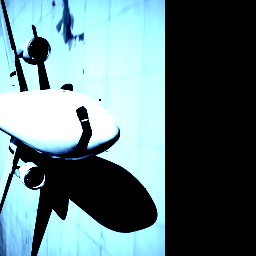

In [26]:
# input_perturbed[100:105,100:105,1:3,1] .= -0.5
input_perturbed[100:101,100:101,1:3,1] .= -0.5
colorview(RGB, permutedims(input_perturbed[:, :, :, 1], [3,1,2]))

In [27]:
input = Float32.(input)
input_perturbed = Float32.(input_perturbed)
image_seeds = ImageConvexHull([input, input_perturbed])  # 256 x 256 x 3 x 2
prop_method = ImageZono()
visualize(search_method, split_method, prop_method, Problem(model, image_seeds, output_set), "center_2x2/";)

Set(Any["BatchNormalization", "Flatten", "Relu", "ConvTranspose", "Conv", "AveragePool", "Add"])
size(bound.generators): (256, 256, 3, 1)
prop time:0.017662783
comp time:0.007722075
saving visualized bound: center_2x2/1_conv_0.png
bound time:0.002177283
prop time:0.000953869
comp time:0.000416638
saving visualized bound: center_2x2/2_batchnorm_0.png
bound time:0.001680553
before order: 

9.5367431640625e-7
non0 ele cnt: 912
overapproximate time: 

0.308604235
after order: 0.00010395050048828125
before size: (128, 128, 64, 1)
after size: (128, 128, 64, 109)
prop time:0.309069145
comp time:0.001084161
saving visualized bound: center_2x2/3_batchnorm_0_relu.png


bound time:0.127925149
prop time:

0.094087442
comp time:0.000669413
saving visualized bound: center_2x2/4_averagepool_0.png
bound time:0.031818827
size(bound.generators): (64, 64, 64, 109)


prop time:0.594764561
comp time:0.003114962
saving visualized bound: center_2x2/5_conv_1.png
bound time:0.032245886
prop time:

0.029030291
comp time:0.000138613
saving visualized bound: center_2x2/6_batchnorm_1.png
bound time:0.031922539
before order: 0.000415802001953125


non0 ele cnt: 1600
overapproximate time: 0.109539692
after order: 0.0005340576171875
before size: (64, 64, 64, 109)
after size: (64, 64, 64, 140)
prop time:0.109883049
comp time:0.000267835
saving visualized bound: center_2x2/7_batchnorm_1_relu.png
bound time:0.041393958


size(bound.generators): (64, 64, 64, 140)


prop time:0.827497288
comp time:0.003682664
saving visualized bound: center_2x2/8_conv_2.png
bound time:0.0425284
prop time:

0.040938589
comp time:0.000138272
saving visualized bound: center_2x2/9_batchnorm_2.png
bound time:0.041279346
add_0


+
saving visualized bound: center_2x2/10_add_0.png
bound time:0.072521371
before order: 0.000949859619140625


non0 ele cnt: 3136
overapproximate time: 

0.484080117
after order: 0.001422882080078125
before size: (64, 64, 64, 249)
after size: (64, 64, 64, 373)
prop time:0.484481855
comp time:0.000129753
saving visualized bound: center_2x2/11_relu_0.png


bound time:0.10798971
size(bound.generators): (64, 64, 64, 373)


prop time:2.014747564


comp time:0.003664404
saving visualized bound: center_2x2/12_conv_3.png


bound time:0.155140034
prop time:

0.102308767
comp time:0.000234044
saving visualized bound: center_2x2/13_batchnorm_3.png


bound time:0.109121994
before order: 0.001422882080078125


non0 ele cnt: 5184
overapproximate time: 

0.594406345
after order: 0.00273895263671875
before size: (64, 64, 64, 373)
after size: (64, 64, 64, 718)
prop time:0.594813213
comp time:0.000125162
saving visualized bound: center_2x2/14_batchnorm_3_relu.png


bound time:0.207832349
size(bound.generators): (64, 64, 64, 718)


prop time:3.908395639
comp time:0.003734995
saving visualized bound: center_2x2/15_conv_4.png


bound time:0.209731536
prop time:

0.189021712
comp time:0.000144333
saving visualized bound: center_2x2/16_batchnorm_4.png


bound time:0.252851089
add_1


+
saving visualized bound: center_2x2/17_add_1.png


bound time:0.343778909
before order: 0.004161834716796875


non0 ele cnt: 7744
overapproximate time: 

1.96936306
after order: 0.006214141845703125
before size: (64, 64, 64, 1091)
after size: (64, 64, 64, 1629)
prop time:1.969777178
comp time:0.000125503
saving visualized bound: center_2x2/18_relu_1.png


bound time:0.549064316
size(bound.generators): (64, 64, 64, 1629)


prop time:6.889156012
comp time:0.001733325
saving visualized bound: center_2x2/19_conv_5.png


bound time:0.306911172
size(bound.generators): (64, 64, 64, 1629)


prop time:2.882391612
comp time:0.000448659
saving visualized bound: center_2x2/20_conv_7.png


bound time:0.292098766
prop time:

0.228264728
comp time:8.0992e-5
saving visualized bound: center_2x2/21_batchnorm_5.png


bound time:0.236625675
prop time:

0.268644316
comp time:0.000108682
saving visualized bound: center_2x2/22_batchnorm_7.png


bound time:0.23481769
before order: 0.01242828369140625


non0 ele cnt: 4608
overapproximate time: 

1.063103276
after order: 0.018341064453125
before size: (32, 32, 128, 1629)
after size: (32, 32, 128, 2404)
prop time:1.063514735
comp time:7.0931e-5
saving visualized bound: center_2x2/23_batchnorm_5_relu.png


bound time:0.346173237
size(bound.generators): (32, 32, 128, 2404)


prop time:12.205717797
comp time:0.003095031
saving visualized bound: center_2x2/24_conv_6.png


bound time:0.350047096
prop time:

0.331126018
comp time:7.8232e-5
saving visualized bound: center_2x2/25_batchnorm_6.png


bound time:0.412266851
add_2


+
saving visualized bound: center_2x2/26_add_2.png


bound time:0.612971687
before order: 0.03076934814453125


non0 ele cnt: 8192
overapproximate time: 

3.539663295
after order: 0.03989410400390625
before size: (32, 32, 128, 4033)
after size: (32, 32, 128, 5229)
prop time:3.540090893
comp time:6.6811e-5
saving visualized bound: center_2x2/27_relu_2.png


bound time:0.865323779
size(bound.generators): (32, 32, 128, 5229)


prop time:25.787131384
comp time:0.003602413
saving visualized bound: center_2x2/28_conv_8.png


bound time:0.754217888
prop time:

0.847021475
comp time:0.000156333
saving visualized bound: center_2x2/29_batchnorm_8.png


bound time:0.756119406
before order: 0.03989410400390625


non0 ele cnt: 12800
overapproximate time: 

3.979269905
after order: 0.06878662109375
before size: (32, 32, 128, 5229)
after size: (32, 32, 128, 9016)
prop time:3.979690634
comp time:6.9521e-5
saving visualized bound: center_2x2/30_batchnorm_8_relu.png


bound time:1.391350952
size(bound.generators): (32, 32, 128, 9016)


prop time:45.447091173
comp time:0.004961029
saving visualized bound: center_2x2/31_conv_9.png


bound time:1.421449311
prop time:

1.33344467
comp time:0.000102922
saving visualized bound: center_2x2/32_batchnorm_9.png


bound time:1.288619541
add_3


+
saving visualized bound: center_2x2/33_add_3.png


bound time:2.020246801
before order: 0.10868072509765625


non0 ele cnt: 18432
overapproximate time: 

10.031013238
after order: 0.161346435546875
before size: (32, 32, 128, 14245)
after size: (32, 32, 128, 21148)
prop time:10.031496387
comp time:6.6802e-5
saving visualized bound: center_2x2/34_relu_3.png


bound time:3.063003615
size(bound.generators): (32, 32, 128, 21148)


prop time:56.906879972
comp time:0.003173575
saving visualized bound: center_2x2/35_conv_10.png


bound time:1.636904417
size(bound.generators): (32, 32, 128, 21148)


prop time:20.006803665
comp time:0.000837356
saving visualized bound: center_2x2/36_conv_12.png


bound time:1.65993477
prop time:

1.892811846
comp time:7.4971e-5
saving visualized bound: center_2x2/37_batchnorm_10.png


bound time:1.481183228
prop time:

1.901825805
comp time:8.8942e-5
saving visualized bound: center_2x2/38_batchnorm_12.png


bound time:1.495041797
before order: 0.32269287109375


non0 ele cnt: 12544
overapproximate time: 

7.329624615
after order: 0.4098358154296875
before size: (16, 16, 256, 21148)
after size: (16, 16, 256, 26859)
prop time:7.330047593
comp time:5.6812e-5
saving visualized bound: center_2x2/39_batchnorm_10_relu.png


bound time:2.014009865
size(bound.generators): (16, 16, 256, 26859)


prop time:115.727661175
comp time:0.003537381
saving visualized bound: center_2x2/40_conv_11.png


bound time:2.186467625
prop time:

5.021816037
comp time:0.000261855
saving visualized bound: center_2x2/41_batchnorm_11.png


bound time:2.430325573
add_4


+
saving visualized bound: center_2x2/42_add_4.png


bound time:3.486302708
before order: 0.7325286865234375


non0 ele cnt: 20599
overapproximate time: 

22.715939345
after order: 0.80340576171875
before size: (16, 16, 256, 48007)
after size: (16, 16, 256, 52652)
prop time:22.716347403
comp time:5.0321e-5
saving visualized bound: center_2x2/43_relu_4.png


bound time:4.091076813
size(bound.generators): (16, 16, 256, 52652)


prop time:222.724767054
comp time:0.004762476
saving visualized bound: center_2x2/44_conv_13.png


bound time:4.041867396
prop time:

4.677672995
comp time:7.0792e-5
saving visualized bound: center_2x2/45_batchnorm_13.png


bound time:3.743554035
before order: 0.80340576171875


non0 ele cnt: 30320
overapproximate time: 

21.24647907
after order: 1.0965118408203125
before size: (16, 16, 256, 52652)
after size: (16, 16, 256, 71861)
prop time:21.25044656
comp time:5.4331e-5
saving visualized bound: center_2x2/46_batchnorm_13_relu.png


bound time:19.990092389


size(bound.generators): (16, 16, 256, 71861)


prop time:317.935266241
comp time:0.012978979
saving visualized bound: center_2x2/47_conv_14.png


bound time:5.858696493
prop time:

6.758059258
comp time:6.5581e-5
saving visualized bound: center_2x2/48_batchnorm_14.png


bound time:5.090691811
add_5


+
saving visualized bound: center_2x2/49_add_5.png


bound time:18.414745582
before order: 

1.8999176025390625


non0 ele cnt: 41983
overapproximate time: 

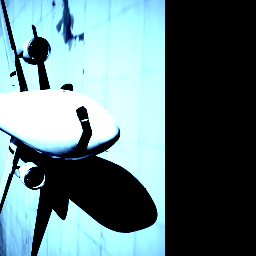

In [15]:
colorview(RGB, permutedims(input[:, :, :, 1], [3,1,2]))

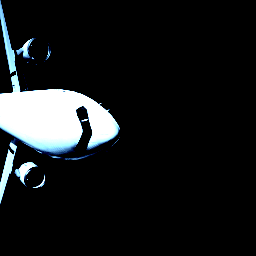

In [12]:
img_pert_path = "./AircraftInspection-no-bg_00000008.png"
csv_path = "./SynthPlane_08.csv"
input_perturbed = preprocess_image(img_pert_path, csv_path)
colorview(RGB, permutedims(input_perturbed[:, :, :, 1], [3,1,2]))

In [17]:
image_seeds = ImageConvexHull([input, input_perturbed])  # 256 x 256 x 3 x 2
visualize(search_method, split_method, prop_method, Problem(model, image_seeds, output_set), "bg/";)

Set(Any["BatchNormalization", "Flatten", "Relu", "ConvTranspose", "Conv", "AveragePool", "Add"])


size(bound.generators): (256, 256, 3, 1)
prop time:0.516802467


comp time:0.514892321
saving visualized bound: bg/1_conv_0.png
bound time:0.002840346
prop time:0.001275009


comp time:0.508096741
saving visualized bound: bg/2_batchnorm_0.png
bound time:0.002055228
before order: 9.5367431640625e-7


non0 ele cnt: 626640


OutOfMemoryError: OutOfMemoryError()